## **Introduction**

Implement an AI real-time Rock-Paper-Scissors game that the users can play against computer. 
In this project, we have just collected 2820 pictures generated by three team members including Rock, Paper, Scissors, and the pictures that are none of these three. 

So, let's get started !

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 請輸入資料夾之所在位置
FOLDERNAME = 'Colab\ Notebooks/Rock_Paper_Scissors_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/$FOLDERNAME

/content/drive/MyDrive/Colab Notebooks/Rock_Paper_Scissors_project


## **Preparing Data - by using Pytorch**

First, we do the data pre-processing and transform the data into Tensor. 

Later, based on the small dataset, we split the data into training (80%) and testing(20%)

In [ ]:
import torch
from torch.utils.data import Dataset, random_split
from torchvision import transforms

import torchvision.transforms as T
import torchvision.datasets as dset
from torch.utils import data
from torch.utils.data import DataLoader
import numpy as np


In [ ]:
# Create a custom dataset 

class Subset(Dataset):
  def __init__(self, subset, transform=None):
    self.subset = subset
    self.transform = transform

  def __getitem__(self, index):
    x, y = self.subset[index]
    if self.transform:
      x = self.transform(x)
    return x, y
  
  def __len__(self):
    return len(self.subset)

In [ ]:
# path_to_dataset = 'Rock_Paper_Scissors_Datasets(new)'
# total data - 4030 img / 11 class  - 83% accuracy
# 11 class - blur, four, middle finger, none, one, paper, rock, scissors, six, three, thumb

path_to_dataset = 'Rock_Paper_Scissors_Datasets(new)'


# path_to_dataset = 'RPC_newdata'

train_transform = T.Compose([T.Resize((128, 128)),
                       T.RandomRotation((-90, +90)),
                      #  T.RandomCrop(size=(256, 256), padding=4),
                       T.RandomHorizontalFlip(p=0.5),
                       T.RandomVerticalFlip(p=0.5),
                       T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                       T.ToTensor()
                       ])

test_transform = T.Compose([T.Resize((128, 128)),
                       T.ToTensor()
                       ])

# Load Rock-Paper-Scissors Data by Pytorch
dataset = dset.ImageFolder(path_to_dataset)

# Split the data into train(80%) and test(20%) - small dataset
lengths = [int(np.ceil(0.8*len(dataset))), int(np.floor(0.2*len(dataset)))]
train_set, test_set = data.random_split(dataset, lengths)

# Data Pre-processing by Pytorch
train_set = Subset(train_set, transform=train_transform)
test_set = Subset(test_set, transform=test_transform)

# Creating Mini-Batches by Pytorch
mini_trains = DataLoader(train_set, batch_size=64, shuffle=True)
print(len(mini_trains))

# Look at the single tensor shape (batch, channels, height, width)
single_batch = next(iter(mini_trains))
single_batch[0].shape

51


torch.Size([64, 3, 128, 128])

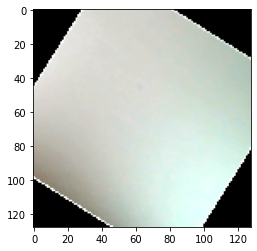

In [ ]:
import matplotlib.pyplot as plt

single_image = single_batch[0][0]
single_image.shape

plt.imshow(single_image.permute(1, 2, 0))

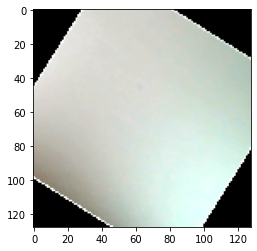

In [ ]:
import matplotlib.pyplot as plt

single_image = single_batch[0][0]
single_image.shape

plt.imshow(single_image.permute(1, 2, 0))

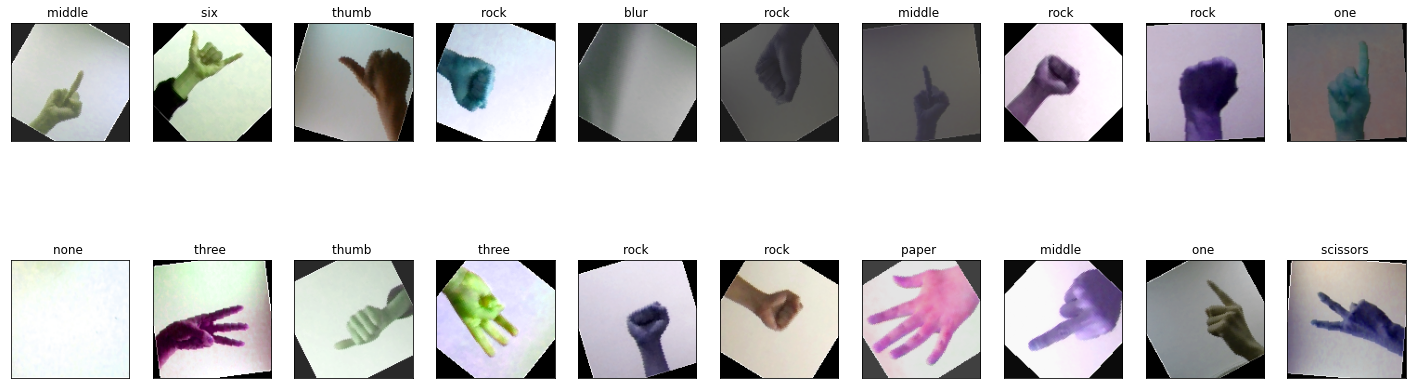

In [ ]:
from torchvision import transforms, utils, datasets

# classes = ['none', 'paper', 'rock', 'scissors']
classes = ['blur', 'four', 'middle', 'none', 'one', 
         'paper', 'rock', 'scissors', 'six', 'three', 'thumb']

def denormalize(image):
  image = image.permute(1, 2, 0)
  image = torch.clamp(image, 0, 1)
  return image

def imshow(img):
  img = denormalize(img)
  plt.imshow(img)

dataiter = iter(mini_trains)
images, labels = dataiter.next()
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize = (25, 8))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title("{} ".format(classes[labels[idx]]))

In [ ]:
# See if GPU is available
# To turn GPU on: Edit -> Notebook Setting -> GPU

import torch

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


## **Selecting the Algorithm and Training the model**


We choose Convolution Nerual Network (CNN) as our algorithm and use pretrained model ResNet. Remember the model and the data must run on GPU not CPU.

In [ ]:
import torch.nn as nn
from torchvision import models

# Load the pre-trained model!
# model_ft = models.googlenet(pretrained=True)
model_ft = models.resnet18(pretrained=True)

d_in = model_ft.fc.in_features
model_ft.fc = nn.Linear(d_in, 11)
# model_ft.fc = nn.Linear(d_in, 4)
model = model_ft

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
# Create model and optimizer for training later 

import torch.optim as optim
learning_rate = 1e-3
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)


In [ ]:
from torchsummary import summary
summary(model.cuda(), (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [ ]:
from tqdm.notebook import tqdm

# create train function to train our model 
def train():

  # Trun on the training mode on my model
  model.train()

  for data, target in tqdm(mini_trains):

    data = data.to(device)
    target = target.to(device)

    optimizer.zero_grad()

    # forward pass: compute predicted outputs by passing inputs to the model
    scores = model(data.float())

    # Choose the loss function - CrossEntropyloss (multi-class)
    loss_function = nn.CrossEntropyLoss()
    loss = loss_function(scores, target)
    
    # Backward pass
    loss.backward()

    # Parameter update
    optimizer.step()


# based on CNN cat and dog structure (train -> accuracy -> epoch )

In [ ]:
# Predict on the train set
def evaluate_predictor():

  model.eval()

  train_loss = 0
  train_acc = 0
  
  for data, target in tqdm(mini_trains):

    data = data.to(device)
    target = target.to(device)

    # Forward pass: compute predicted outputs by passing inputs to the model
    scores = model(data.float())

    # Choose the loss function - CrossEntropyloss
    loss_function = nn.CrossEntropyLoss()
    loss = loss_function(scores, target)

    # Calculate the loss
    train_loss += loss.item()*data.size(0)
    prediction = scores.data.max(1)[1]    # why max(1) inside has 1 ? return the biggest number in that row?
    acc = prediction.eq(target).sum().item()
    train_acc += acc

  # Calculate average losses
  train_loss = train_loss / len(mini_trains.dataset)
  train_acc = train_acc / len(mini_trains.dataset)
  return train_loss, train_acc


## **Testing our Model's Accuracy** ##

We evaluate the model against test data.

Result can give us some idea in how we might revise the workflow steps to improve the performance.

In [ ]:
# Train the data
for epoch in range(10):
  print('Epoch: {}'.format(epoch+1))
  train()
  train_loss, train_acc = evaluate_predictor()

  print('\tTraining Loss: {:.6f}\tTraining Acc: {:.6f}'.format(train_loss, train_acc))

Epoch: 1



	Training Loss: 1.368242	Training Acc: 0.534204
Epoch: 2



	Training Loss: 0.765103	Training Acc: 0.742848
Epoch: 3



	Training Loss: 0.551984	Training Acc: 0.817164
Epoch: 4



	Training Loss: 0.399922	Training Acc: 0.880597
Epoch: 5



	Training Loss: 0.336244	Training Acc: 0.903296
Epoch: 6



	Training Loss: 0.281743	Training Acc: 0.924751
Epoch: 7



	Training Loss: 0.227198	Training Acc: 0.932525
Epoch: 8



	Training Loss: 0.203142	Training Acc: 0.938433
Epoch: 9



	Training Loss: 0.183576	Training Acc: 0.946517
Epoch: 10



	Training Loss: 0.165584	Training Acc: 0.949938


In [ ]:
mini_tests = DataLoader(test_set, batch_size = 64, shuffle = True)

In [ ]:
model.eval()
test_acc = 0
for data, target in tqdm(mini_tests):
  data = data.to(device)
  target = target.to(device)
  scores = model(data)
  prediction = scores.data.max(1)[1]
  acc = prediction.eq(target).sum().item()
  test_acc += acc

# calculate average losses
test_acc = test_acc / len(mini_tests.dataset)
print('Test Acc:', test_acc)

In [ ]:
torch.save(model, 'RPS_model_resnet.pt')